In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from utilities.dataset import CustomDataset
from utilities.constants import PATH, ROWS, COLS, TRAIN_SIZE, VALID_SIZE, TEST_SIZE
from utilities.transforms import transforms
from utilities.training import fit
from utilities.models import CarClassifierV0
from utilities.utils import get_mean_and_std, loss_plot, acc_plot
from torchmetrics import F1Score

/home/okechukwu/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = CustomDataset(root_dir=PATH, transforms=transforms)

In [3]:
len(ds) - TRAIN_SIZE - VALID_SIZE

371

In [4]:
train_ds, valid_ds, test_ds  = random_split(ds, [TRAIN_SIZE, VALID_SIZE, TEST_SIZE])

In [5]:
len(train_ds), len(test_ds)

(2264, 371)

In [6]:
mean, std = get_mean_and_std(train_ds)
mean, std

(tensor([0.3332, 0.3320, 0.3337]), tensor([0.3308, 0.3285, 0.3301]))

In [7]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle = True)
test_dl = DataLoader(test_ds, shuffle = False)
valid_dl = DataLoader(valid_ds, shuffle = False)

In [8]:
train_image_batch, train_image_label = next(iter(train_dl))

In [9]:
class_names= list(ds.class_to_idx.keys())
class_names

['sandero',
 'chevroulet aveo',
 'mercedes class a',
 'hyundai tucson',
 'picanto',
 'toyota corolla',
 'bmw serie 1',
 'chevrolet spark',
 'duster',
 'polo',
 'megane',
 'octavia',
 'seat ibiza',
 'logan',
 'hyundai i10',
 'clio',
 'nemo citroen',
 'symbol',
 'Golf',
 'volkswagen tiguan']

In [10]:
train_image_batch[2], train_image_label[2], class_names[train_image_label[2].argmax()]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 'octavia')

In [11]:
print(f'Shape of the each image -> {train_image_batch[0].shape}')

Shape of the each image -> torch.Size([3, 224, 224])


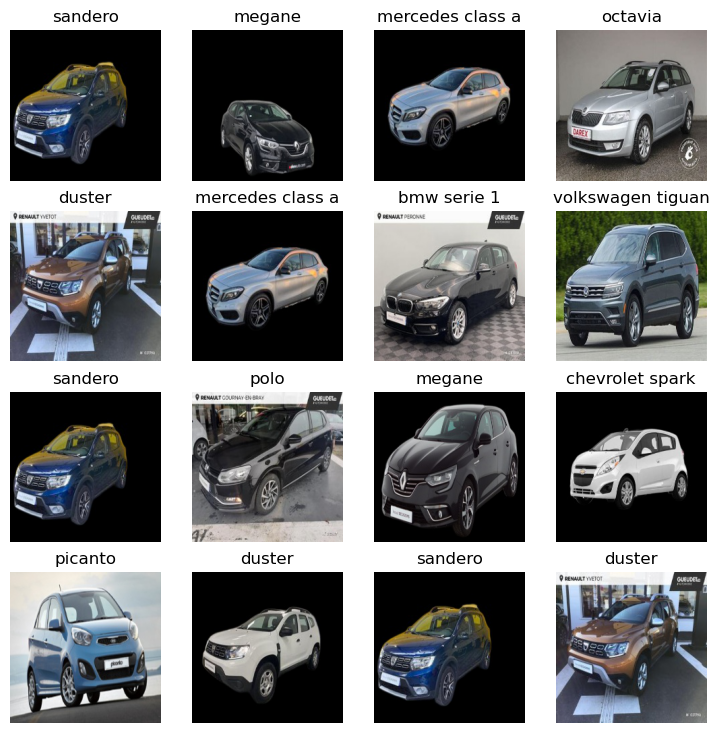

In [12]:
fig = plt.figure(figsize = (9,9))


for i in range(1, ROWS*COLS+1):
    random_idx = torch.randint(0, len(train_image_batch), size = [1]).item()
    img_data, label = train_image_batch[random_idx], train_image_label[random_idx]
    img = np.transpose(img_data.squeeze(), (1,2,0))
    fig.add_subplot(ROWS, COLS, i)
    plt.imshow(img)
    plt.title(class_names[label.argmax()])
    plt.axis('Off')

In [13]:
model_0 = CarClassifierV0(len(class_names), mean = mean, std = std)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=1e-2)
acc_fn = F1Score(task = 'multiclass', num_classes=len(class_names))

In [15]:
model_0

CarClassifierV0(
  (normalize): Normalize(mean=tensor([0.3332, 0.3320, 0.3337]), std=tensor([0.3308, 0.3285, 0.3301]))
  (input_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (features): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
  )
  (output): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=141376, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=20, bias=True)
 

In [16]:
numel_list = [p.numel() for p in model_0.parameters()]
sum(numel_list)

141607740

In [17]:
pred = model_0(train_image_batch[0].unsqueeze(dim = 0))

In [18]:
train_image_batch[0].unsqueeze(dim = 0).shape

torch.Size([1, 3, 224, 224])

In [19]:
pred.shape, train_image_label[0].shape

(torch.Size([1, 20]), torch.Size([20]))

In [20]:
loss = criterion(pred, train_image_label[0].unsqueeze(dim = 0))

In [21]:
acc_fn(pred, train_image_label[0].unsqueeze(dim = 0)).item() * 100

0.0

In [22]:
loss

tensor(3.0084, grad_fn=<DivBackward1>)

In [23]:
loss.backward()

In [24]:
history = fit(10,  model_0, train_dl, test_dl, criterion, acc_fn, optimizer, device = 'cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train Loss -> 2.949, Training Accuracy : 0.0%
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1,

 10%|█         | 1/10 [04:14<38:09, 254.40s/it]

torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
Test Loss -> 2.940 | Test Loss -> 0.0%
Epoch: 1
Train Loss -> 2.907, Training Accuracy : 0.0%
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 2

 20%|██        | 2/10 [08:22<33:27, 250.92s/it]

torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
Test Loss -> 2.917 | Test Loss -> 0.0%
Epoch: 2
Train Loss -> 2.876, Training Accuracy : 0.0%
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 2

 30%|███       | 3/10 [12:25<28:48, 246.98s/it]

torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
Test Loss -> 2.896 | Test Loss -> 0.0%
Epoch: 3
Train Loss -> 2.846, Training Accuracy : 0.0%
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
torch.Size([1, 3, 224, 2

 40%|████      | 4/10 [16:41<25:03, 250.52s/it]

torch.Size([1, 3, 224, 224])
torch.Size([1, 20])
Test Loss -> 2.863 | Test Loss -> 0.0%
Epoch: 4


 40%|████      | 4/10 [17:11<25:47, 257.97s/it]


KeyboardInterrupt: 

In [ ]:
len(class_names)

In [ ]:
history['epochs']

In [ ]:
loss_plot(history=history)

In [ ]:
acc_plot(history=history)

In [ ]:
torch.tensor([10, 12]).detach().numpy()